In [1]:
# import libraries
import numpy as np
import pandas as pd 
from scipy.stats import skew


# machine learning 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

# lightgbm model 
import lightgbm as lgb

In [2]:
pip install verstack 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 67.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for verstack: filename=verstack-3.6.7-py3-none-any.whl size=79844 sha256=238de64efbc2ee0ea

In [3]:
# import LGBTuner 
from verstack import LGBMTuner

# Read Data and Transform Data 

In [4]:
# read dataset
df = pd.read_csv("/kaggle/input/playground-series-s3e11/train.csv")
df_origins = pd.read_csv("/kaggle/input/media-campaign-cost-prediction/train_dataset.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s3e11/test.csv")

In [5]:
df = pd.concat([df, df_origins], axis=0)

In [7]:
# no transformation 
# X_train, y_train = df.iloc[:,1:-1], df.iloc[:,-1]
# X_test = df_test.iloc[:,1:]

In [8]:
# partial transformation
transform = ColumnTransformer(transformers=[
    ('standardize', StandardScaler(), ['total_children', 'avg_cars_at home(approx).1',
       'gross_weight', 'recyclable_package', 'low_fat', 'units_per_case',
       'store_sqft', 'coffee_bar', 'video_store', 'salad_bar', 'prepared_food',
       'florist']),
    ('passthrough', 'passthrough', ['store_sales(in millions)', 'unit_sales(in millions)',
    'num_children_at_home'])
])

X_train, y_train= df.iloc[:,1:-1], df.iloc[:,-1]
X_test = df_test.iloc[:,1:]

X_train_trans = transform.fit_transform(X_train)
X_test_trans = transform.fit_transform(X_test)

# Tuning the LightGBM


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 300 trials
     .. Evaluation metric: rmsle 
     .. Study direction: minimize rmsle

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmsle: 0.3017469376372419
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmsle: 0.3018216108800283
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmsle: 0.30082440917752185
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmsle: 0.3015917006645914
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmsle: 0.30074510953712547
 .....................................

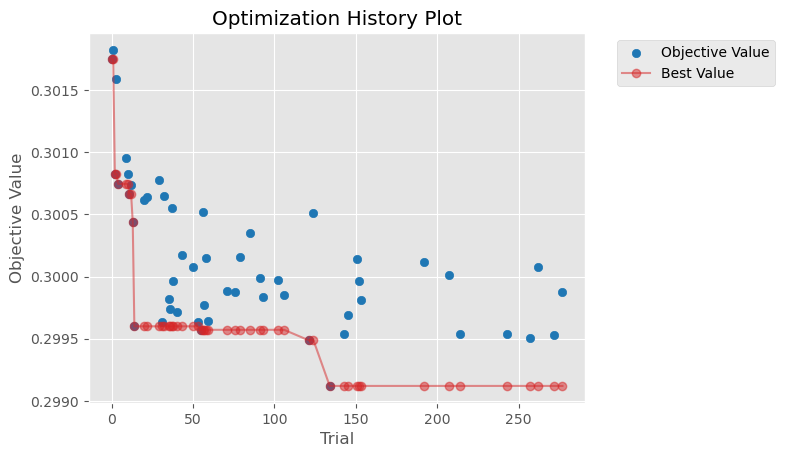

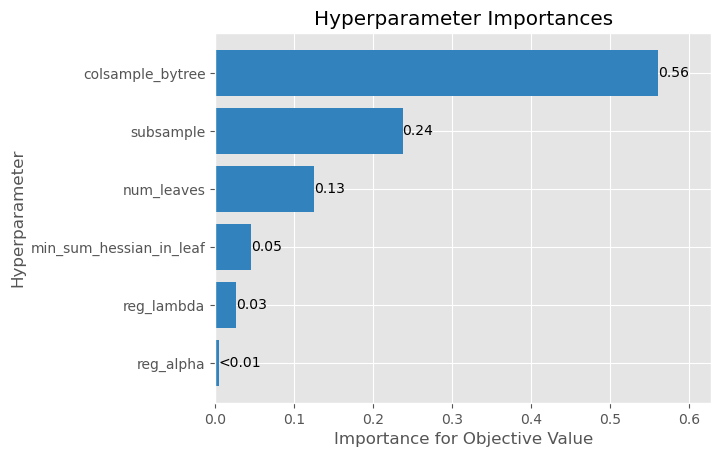

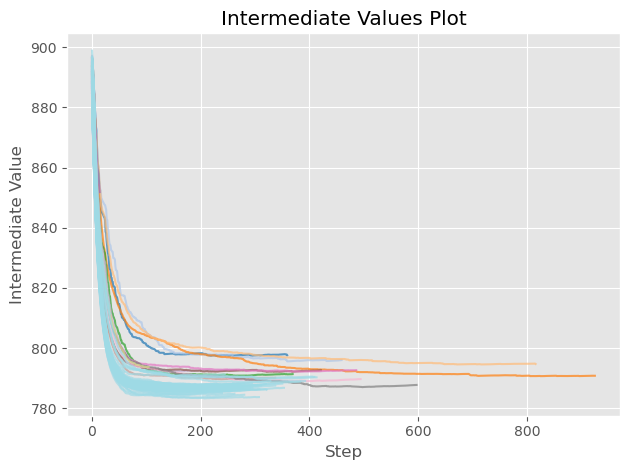

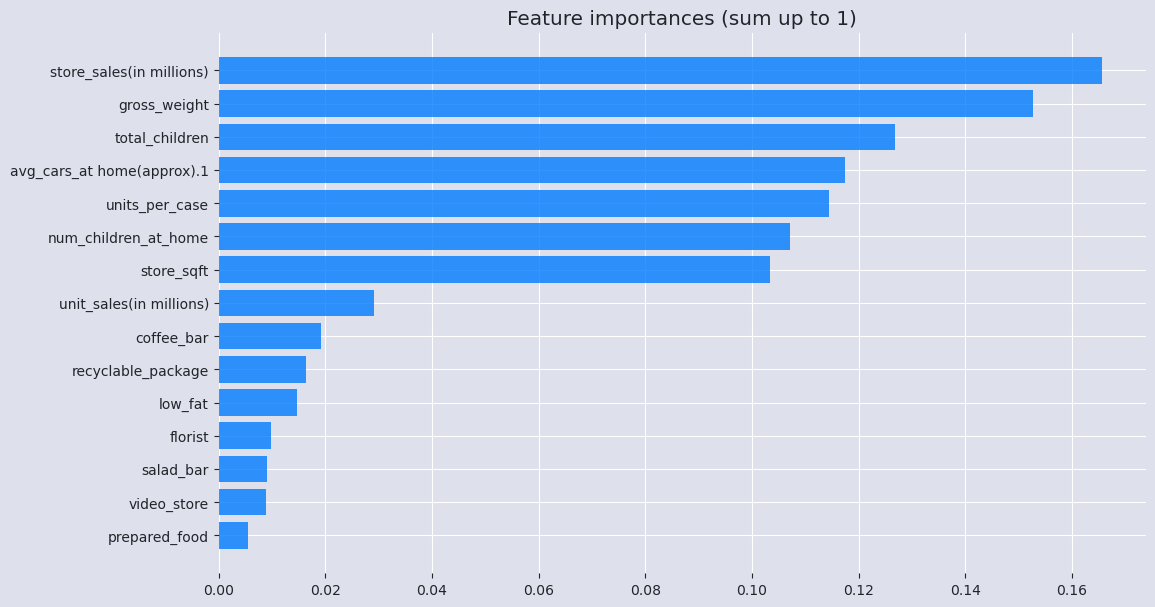


     . Optuna hyperparameters optimization finished
     .. Best trial number:134    |     rmsle:           0.2991208277818118
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  159   |     rmsle:          0.30063812960744496

Time elapsed for fit execution: 17 min 32.303 sec


In [10]:
# partial normalization training 
X = pd.DataFrame(X_train_trans, columns=list(df.columns[1:-1]))
y = pd.DataFrame(y_train)
tuner = LGBMTuner(metric='rmsle', trials=300, device_type='gpu')
tuner.fit(X_train, y_train)

In [11]:
X_test_df = pd.DataFrame(X_test_trans, columns=list(df_test.columns[1:]))
y_pred = tuner.predict(X_test_df)

pred_cost = pd.DataFrame(y_pred, columns=['cost'])
submission_df = pd.concat([df_test['id'], pred_cost], axis=1)
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,id,cost
0,360336,103.675979
1,360337,94.571408
2,360338,97.083149
3,360339,90.922542
4,360340,102.317779
